In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
from scipy.sparse.csgraph import connected_components

def calculate_entropy(df,threshold):
    corr = (np.abs(df.corr().values)>threshold).astype(int)
    _, labels = connected_components(corr)
    _, count = np.unique(labels, return_counts=True)
    count_norm = count / count.sum()    
    return -np.nansum(count_norm*np.log2(count_norm))

def get_entropy(df, sequence_length, step=1, corr_threshold=0.5):
    assert df.isna().sum().sum()==0
    entropy_dict = {'index':[], 'structural_entropy':[]}

    for i in range(sequence_length, df.shape[0],step):        
        entropy_dict['index'].append(df.index[i])
        entropy_dict['structural_entropy'].append(calculate_entropy(df.iloc[i-sequence_length:i-1,:],corr_threshold))        

    return pd.Series(entropy_dict['structural_entropy'], index=entropy_dict['index'])

### Example on trail data

In [16]:
df = pd.read_csv('./data/burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv')
df['Date']= pd.to_datetime(df['Date'])
df = df[['Ped South','Ped North','Bike North','Bike South','Date']].resample('1D', on='Date').sum()

/home/ning/python3.7-virtualenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ning/python3.7-virtualenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ning/python3.7-virtualenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

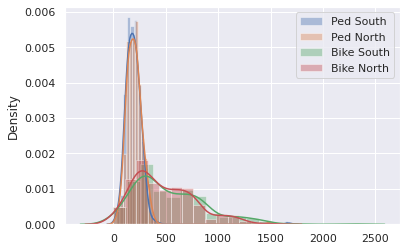

In [18]:
year19_df = df[(df.index>='2019-01-01') & (df.index<'2020-01-01')].copy()
sns.distplot(year19_df['Ped South'], label='Ped South')
sns.distplot(year19_df['Ped North'], label='Ped North')
sns.distplot(year19_df['Bike South'], label='Bike South')
sns.distplot(year19_df['Bike North'], label='Bike North')
plt.legend()
plt.xlabel('')
plt.show()

<Figure size 864x288 with 0 Axes>

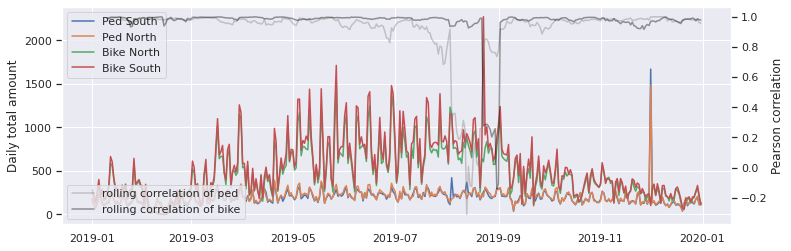

In [73]:
win = 10

plt.figure(figsize=(12,4))
year19_df['rolling_corr_ped'] = year19_df['Ped South'].rolling(win).corr(year19_df['Ped North'])
year19_df['rolling_corr_bike'] = year19_df['Bike South'].rolling(win).corr(year19_df['Bike North'])

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
for col in df.columns:
    ax1.plot(year19_df[col], label=col)
ax1.legend()
ax1.set_ylabel('Daily total amount')

ax2 = ax1.twinx()
ax2.plot(year19_df['rolling_corr_ped'], label='rolling correlation of ped',color='grey', alpha=0.4,)    
ax2.plot(year19_df['rolling_corr_bike'], label='rolling correlation of bike',color='black', alpha=0.4,)    
ax2.legend()
ax2.set_ylabel('Pearson correlation')
ax2.grid(False)
plt.show()

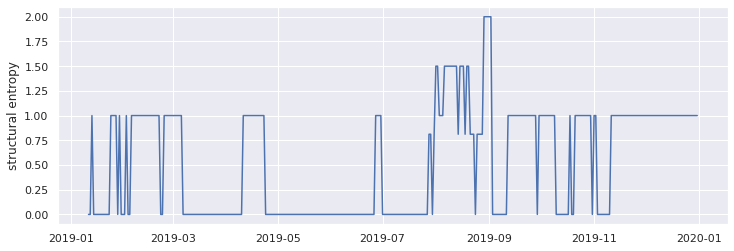

In [72]:
win = 10
entropy = get_entropy(year19_df[['Ped South','Ped North','Bike North','Bike South']], 
                      sequence_length=win, step=1, corr_threshold = 0.8)
year19_df['s_entropy'] = entropy

plt.figure(figsize=(12,4))
plt.plot(year19_df['s_entropy'])
plt.ylabel('structural entropy')
plt.show()

In [20]:
year19_df.head()

,Ped South,Ped North,Bike North,Bike South
Date,,,,
2019-01-01,178.0,186.0,245.0,284.0
2019-01-02,107.0,103.0,212.0,223.0
2019-01-03,72.0,88.0,130.0,131.0
2019-01-04,119.0,125.0,223.0,244.0
2019-01-05,220.0,221.0,367.0,401.0


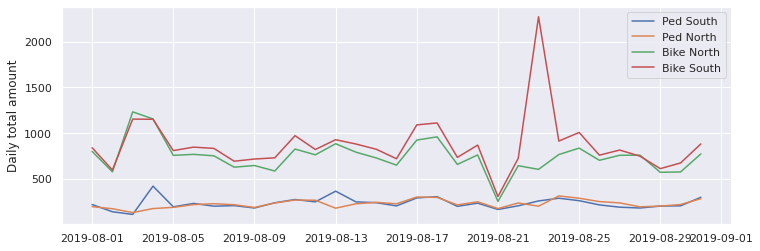

In [22]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
for col in df.columns:
    ax1.plot(year19_df[(year19_df.index>='2019-08-01') & (year19_df.index<'2019-09-01')][col], label=col)
ax1.legend()
ax1.set_ylabel('Daily total amount')
plt.show()

### Example on stock market

In [5]:
history_df = pd.read_pickle(f'../trade/data_ca/history_df.pkl')
history_df = history_df.set_index('symbol').sort_values('date')

In [6]:
stocks_agg_df = history_df.groupby('symbol').agg({'adj close':['min','max','mean'],
                                                                'volume':['min','median'],
                                                                'date':['min','nunique']})
stocks_agg_df.columns = [x[0]+'_'+x[1] for x in stocks_agg_df.columns]

target_symbols= stocks_agg_df[(stocks_agg_df['date_min']<'2013-01-01') 
              & (stocks_agg_df['volume_median']>2000)
              & (stocks_agg_df['adj close_mean']>1)                 
             ].index.values

len(target_symbols)

327

In [7]:
def process_daily(history_df, symbols):         
    dfs = []
    for symbol in symbols:        
        symbol_df = history_df.loc[symbol,['adj close','volume','date']].reset_index()
        symbol_df['return'] = symbol_df['adj close'].pct_change(1)
        dfs.append(symbol_df)            
    return pd.concat(dfs,axis=0)

daily_df = process_daily(history_df, target_symbols)
daily_df = daily_df.set_index('symbol')    
daily_df.shape

(818892, 4)

In [8]:
stocks = daily_df.reset_index().pivot(index='date',columns='symbol',values='return').dropna().reset_index()
stocks.shape

(2227, 328)

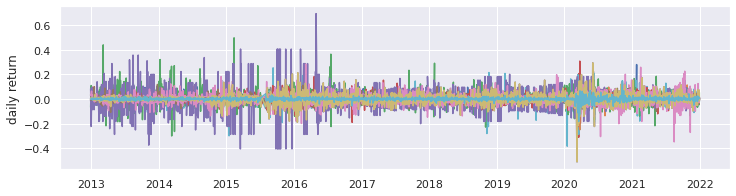

In [9]:
plt.figure(figsize=(12,3))
for col in random.choices(target_symbols,k=20):
    plt.plot(stocks['date'], np.clip(np.log1p(stocks[col]),-1,1))
plt.ylabel('daily return')
plt.show()

In [13]:
win = 20
entropy = get_entropy(stocks[target_symbols], sequence_length=win, step=1,corr_threshold = 0.8)
stocks.loc[np.arange(win,len(stocks)),'s_entropy'] = entropy.values

Text(0, 0.5, 'entropy')

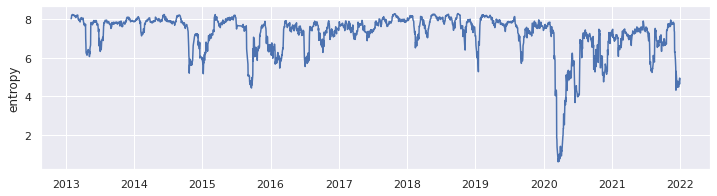

In [14]:
plt.figure(figsize=(12,3))
plt.plot(stocks['date'], stocks['s_entropy'])
plt.ylabel('entropy')